## Project Objectives

- Objective: hourly energy demand
- Target: load, price
- Type: day ahead (24h)

## Datasets

1. energy_dataset:

    Power system (actuals by hour)
    - time — Timestamp of the delivery hour (usually ISO 8601). Use UTC internally; handle DST carefully.

    - generation biomass — Electricity generated from biomass, in MW (instantaneous average over the hour).

    - generation fossil brown coal/lignite — Lignite-fired generation, MW.

    - generation fossil coal-derived gas — Coal-gas derived generation, MW.

    - generation fossil gas — Natural gas generation, MW.

    - generation fossil hard coal — Hard/bituminous coal generation, MW.

    - generation fossil oil — Oil-fired generation, MW.

    - generation fossil oil shale — Oil-shale–based generation, MW.

    - generation fossil peat — Peat-fueled generation, MW.

    - generation geothermal — Geothermal generation, MW.

    - generation hydro pumped storage aggregated — Net pumped-storage generation (aggregate), MW (positive = generating).

    - generation hydro pumped storage consumption — Pumped-storage pumping load/consumption, MW (positive = consuming).

    - generation hydro run-of-river and poundage — Run-of-river hydro generation, MW.

    - generation hydro water reservoir — Reservoir hydro generation, MW.

    - generation marine — Tidal/wave (marine) generation, MW.

    - generation nuclear — Nuclear generation, MW.

    - generation other — Other unspecified generation sources, MW.

    - generation other renewable — Other renewables not listed elsewhere (e.g., biomass waste-to-energy if categorized so), MW.

    - generation solar — Solar PV generation, MW.

    - generation waste — Waste-to-energy generation, MW.

    - generation wind offshore — Offshore wind generation, MW.

    - generation wind onshore — Onshore wind generation, MW.

    Forecasts (known at/ before the forecast time)

    - forecast solar day ahead — Day-ahead solar generation forecast, MW for each hour of the next day (feature; avoid using realized future solar).

    - forecast wind offshore day ahead (your list says “offshore eday ahead”; assume a typo) — Day-ahead offshore wind forecast, MW.

    - forecast wind onshore day ahead — Day-ahead onshore wind forecast, MW.

    - total load forecast — System load forecast made day-ahead or intra-day, MW (feature; do not use future actuals).

    - price day ahead — Day-ahead market price for the delivery hour, EUR/MWh (can be negative).

    Load & price targets
    - total load actual — Realized system load (demand), MW.

    - price actual — Realized/settlement price (if provided; may be balancing or intraday realized), EUR/MWh.

2. Weather (typically hourly, by city/area)
    - dt_iso — Weather observation/forecast timestamp (ISO 8601; confirm whether this is UTC or local from the source).

    - city_name — Name/identifier of the weather location (join key if multiple stations).

    - temp — Air temperature at 2 m, °C.

    - temp_min — Min temperature over the last/next observation window, °C (API-dependent).

    - temp_max — Max temperature over the last/next observation window, °C.

    - pressure — Atmospheric pressure at sea level, hPa.

    - humidity — Relative humidity, %.

    - wind_speed — Wind speed, typically m/s (sometimes km/h; check the data source).

    - wind_deg — Wind direction in degrees (0–360, meteorological).

    - rain_1h — Rainfall volume in the last 1 h, mm.

    - rain_3h — Rainfall volume in the last 3 h, mm.

    - snow_3h — Snowfall volume in the last 3 h, mm (water equivalent).

    - clouds_all — Cloudiness, % (0–100).

    - weather_id — Weather condition code (numeric category).

    - weather_main — High-level weather category (e.g., Rain, Snow).

    - weather_description — Human-readable description (e.g., “light rain”).

    - weather_icon — Icon code string (display-only; not predictive).

## Global Configs

In [2]:
1+1

2

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error 
import warnings
warnings.filterwarnings("ignore")

In [4]:
# display all pandas columns
pd.set_option('display.max_columns', None)

# display first few rows of the DataFrame
pd.set_option('display.max_rows', 200)


## 1. Global EDA

In [5]:
energy_data = pd.read_csv("/Users/shanzhonghan/Documents/Data/energy_dataset.csv", parse_dates=["time"])
weather_data = pd.read_csv("/Users/shanzhonghan/Documents/Data/weather_features.csv", parse_dates=["dt_iso"])

### 1.1 Energy dataset

In [6]:
energy_data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [7]:
energy_data.head(200)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
5,2015-01-01 05:00:00+01:00,410.0,178.0,0.0,4038.0,3590.0,156.0,0.0,0.0,0.0,NaN,2109.0,952.0,743.0,0.0,7098.0,43.0,74.0,34.0,188.0,0.0,4618.0,4.0,NaN,4617.0,21441.0,19905.0,35.72,53.63
6,2015-01-01 06:00:00+01:00,401.0,172.0,0.0,4040.0,3368.0,158.0,0.0,0.0,0.0,NaN,2108.0,961.0,848.0,0.0,7098.0,43.0,74.0,34.0,186.0,0.0,4397.0,3.0,NaN,4276.0,21285.0,20010.0,35.13,51.73
7,2015-01-01 07:00:00+01:00,408.0,172.0,0.0,4030.0,3208.0,160.0,0.0,0.0,0.0,NaN,2031.0,983.0,1012.0,0.0,7099.0,43.0,72.0,35.0,189.0,0.0,3992.0,12.0,NaN,3994.0,21545.0,20377.0,36.22,51.43
8,2015-01-01 08:00:00+01:00,413.0,177.0,0.0,4052.0,3335.0,161.0,0.0,0.0,0.0,NaN,2119.0,1001.0,1015.0,0.0,7098.0,43.0,73.0,54.0,198.0,0.0,3629.0,39.0,NaN,3602.0,21443.0,20094.0,32.40,48.98
9,2015-01-01 09:00:00+01:00,419.0,177.0,0.0,4137.0,3437.0,163.0,0.0,0.0,0.0,NaN,2170.0,1041.0,1357.0,0.0,7097.0,43.0,74.0,743.0,198.0,0.0,3073.0,784.0,NaN,3212.0,21560.0,20637.0,36.60,54.20


In [8]:
# Overall information
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [9]:
# number of unique 
energy_data.nunique()

time                                           35064
generation biomass                               423
generation fossil brown coal/lignite             956
generation fossil coal-derived gas                 1
generation fossil gas                           8297
generation fossil hard coal                     7266
generation fossil oil                            321
generation fossil oil shale                        1
generation fossil peat                             1
generation geothermal                              1
generation hydro pumped storage aggregated         0
generation hydro pumped storage consumption     3311
generation hydro run-of-river and poundage      1684
generation hydro water reservoir                7029
generation marine                                  1
generation nuclear                              2388
generation other                                 103
generation other renewable                        78
generation solar                              

In [10]:
# Drop null columns, constant columns, useless columns
drop_cols = ["generation fossil coal-derived gas", 
             "generation fossil oil shale", 
             "generation fossil peat", 
             "generation geothermal", 
             "generation hydro pumped storage aggregated", 
             "generation marine", 
             "generation wind offshore", 
             "forecast wind offshore eday ahead",
             "price day ahead",
             "total load forecast"
             ]

energy_data = energy_data.drop(columns=drop_cols)

In [11]:
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 19 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [12]:
# Convert time column to datetime type and set it as index
energy_data["time"] = pd.to_datetime(energy_data["time"], utc=True, infer_datetime_format=True).dt.floor("h")
energy_data = energy_data.set_index("time").sort_index()

In [13]:
# duplicated rows
duplicate_rows = energy_data[energy_data.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

Number of duplicate rows: 0


In [14]:
# time continuity check
time_diff = energy_data.index.to_series().diff().dropna()
missing_intervals = time_diff[time_diff != pd.Timedelta(hours=1)]
print(f"Number of missing time intervals: {len(missing_intervals)}")

Number of missing time intervals: 0


In [15]:
# null values
energy_data.isnull().sum()

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load actual                              36
price actual                                    0
dtype: int64

In [16]:
# total rows
total_rows = energy_data.shape[0]
print(f"Total rows: {total_rows}")

Total rows: 35064


Comparing the total number of the samples, there are only few missing features. We only need to check the target column: total load actual:

In [17]:
# find the missing rows of the target column 'total load actual'
missing_target_rows = energy_data[energy_data["total load actual"].isnull()]

missing_target_rows

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load actual,price actual
time,,,,,,,,,,,,,,,,,,
2015-01-05 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3932.0,9258.0,NaN,79.14
2015-01-05 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4236.0,9156.0,NaN,73.95
2015-01-05 13:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4215.0,9072.0,NaN,71.93
2015-01-05 14:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4050.0,8779.0,NaN,71.50
2015-01-05 15:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3728.0,8426.0,NaN,71.85
2015-01-05 16:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3175.0,7946.0,NaN,80.53
2015-01-28 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4136.0,6223.0,NaN,77.62
2015-02-01 06:00:00+00:00,449.0,312.0,4765.0,5269.0,222.0,480.0,980.0,1174.0,7101.0,44.0,75.0,48.0,208.0,3289.0,18.0,3141.0,NaN,16.98
2015-02-01 07:00:00+00:00,453.0,312.0,4938.0,5652.0,288.0,0.0,1031.0,3229.0,7099.0,44.0,75.0,73.0,207.0,3102.0,63.0,3165.0,NaN,19.56


The gaps are scattered across the time range, so we apply a forward fill to impute short gaps and remove any initial missing values.

In [18]:
print(f"total rows: {energy_data.shape[0]}, missing target rows: {missing_target_rows.shape[0]} before imputation:")
energy_data = energy_data.ffill().dropna()
energy_data.isnull().sum()

total rows: 35064, missing target rows: 36 before imputation:


generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load actual                              0
price actual                                   0
dtype: int64

In [19]:
print(f"Data shape after cleaning: {energy_data.shape}")

Data shape after cleaning: (35064, 18)


In [20]:
# Overall information after cleaning
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35064 non-null  float64
 1   generation fossil brown coal/lignite         35064 non-null  float64
 2   generation fossil gas                        35064 non-null  float64
 3   generation fossil hard coal                  35064 non-null  float64
 4   generation fossil oil                        35064 non-null  float64
 5   generation hydro pumped storage consumption  35064 non-null  float64
 6   generation hydro run-of-river and poundage   35064 non-null  float64
 7   generation hydro water reservoir             35064 non-null  float64
 8   generation nuclear                           35064 non-null  float64
 9   generation other         

### 1.2 Weather

In [21]:
weather_data[weather_data["city_name"]=="Seville"].head(10)

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
142839,2015-01-01 00:00:00+01:00,Seville,273.375,273.375,273.375,1039,75,1,21,0.0,0.0,0.0,0,800,clear,sky is clear,01n
142840,2015-01-01 01:00:00+01:00,Seville,273.375,273.375,273.375,1039,75,1,21,0.0,0.0,0.0,0,800,clear,sky is clear,01n
142841,2015-01-01 02:00:00+01:00,Seville,274.086,274.086,274.086,1039,71,3,27,0.0,0.0,0.0,0,800,clear,sky is clear,01n
142842,2015-01-01 03:00:00+01:00,Seville,274.086,274.086,274.086,1039,71,3,27,0.0,0.0,0.0,0,800,clear,sky is clear,01n
142843,2015-01-01 04:00:00+01:00,Seville,274.086,274.086,274.086,1039,71,3,27,0.0,0.0,0.0,0,800,clear,sky is clear,01n
142844,2015-01-01 05:00:00+01:00,Seville,274.592,274.592,274.592,1039,81,4,57,0.0,0.0,0.0,0,800,clear,sky is clear,01n
142845,2015-01-01 06:00:00+01:00,Seville,274.592,274.592,274.592,1039,81,4,57,0.0,0.0,0.0,0,800,clear,sky is clear,01n
142846,2015-01-01 07:00:00+01:00,Seville,274.592,274.592,274.592,1039,81,4,57,0.0,0.0,0.0,0,800,clear,sky is clear,01n
142847,2015-01-01 08:00:00+01:00,Seville,275.651,275.651,275.651,1041,73,2,32,0.0,0.0,0.0,0,800,clear,sky is clear,01d
142848,2015-01-01 09:00:00+01:00,Seville,275.651,275.651,275.651,1041,73,2,32,0.0,0.0,0.0,0,800,clear,sky is clear,01d


In [22]:
# convert dt_iso to datetime
weather_data["time"] = pd.to_datetime(weather_data["dt_iso"], utc=True, infer_datetime_format=True).dt.floor("h")
weather_data = weather_data.drop(columns=["dt_iso"])

In [23]:
# Overall information
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   city_name            178396 non-null  object             
 1   temp                 178396 non-null  float64            
 2   temp_min             178396 non-null  float64            
 3   temp_max             178396 non-null  float64            
 4   pressure             178396 non-null  int64              
 5   humidity             178396 non-null  int64              
 6   wind_speed           178396 non-null  int64              
 7   wind_deg             178396 non-null  int64              
 8   rain_1h              178396 non-null  float64            
 9   rain_3h              178396 non-null  float64            
 10  snow_3h              178396 non-null  float64            
 11  clouds_all           178396 non-null  int64              
 12  we

In [24]:
# number of unique
print("total rows:", weather_data.shape[0])
weather_data.nunique()

total rows: 178396


city_name                  5
temp                   20743
temp_min               18553
temp_max               18591
pressure                 190
humidity                 100
wind_speed                36
wind_deg                 361
rain_1h                    7
rain_3h                   89
snow_3h                   66
clouds_all                97
weather_id                38
weather_main              12
weather_description       43
weather_icon              24
time                   35064
dtype: int64

In [25]:
weather_data["rain_1h"].unique()

array([ 0.  ,  0.3 ,  0.9 ,  3.  , 12.  ,  2.29,  0.25])

In [26]:
weather_data["rain_3h"].unique()

array([0.000e+00, 2.000e-03, 8.000e-02, 9.000e-02, 8.500e-02, 1.000e-02,
       1.000e-03, 1.100e-02, 1.500e-02, 1.400e-02, 1.200e-02, 3.500e-02,
       2.000e-02, 2.500e-02, 1.000e-01, 2.200e-02, 9.500e-02, 5.800e-02,
       1.300e-02, 4.000e-02, 5.000e-03, 2.700e-02, 3.200e-02, 3.000e-02,
       5.200e-02, 3.700e-02, 9.800e-02, 1.800e-02, 7.200e-02, 8.000e-03,
       7.000e-03, 9.300e-02, 5.000e-02, 6.000e-02, 9.000e-03, 4.500e-02,
       4.900e-02, 2.500e-03, 1.250e-02, 7.000e-02, 2.750e-02, 7.500e-03,
       6.500e-02, 6.900e-02, 8.700e-02, 3.000e-03, 4.400e-02, 7.500e-02,
       4.700e-02, 5.500e-02, 6.000e-03, 2.900e-02, 6.700e-02, 4.300e-02,
       5.250e-02, 1.050e-02, 4.000e-03, 2.400e-02, 5.900e-02, 2.100e-02,
       4.800e-02, 5.600e-02, 5.700e-02, 8.200e-02, 2.600e-02, 3.300e-02,
       7.400e-02, 8.400e-02, 6.600e-02, 3.800e-02, 7.300e-02, 9.700e-02,
       5.100e-02, 6.800e-02, 8.300e-02, 5.750e-02, 4.750e-02, 8.750e-02,
       2.250e-02, 7.250e-02, 8.900e-02, 1.750e-02, 

In [27]:
# for the sake of simplicity, we will only keep objective column: weather_description
weather_data = weather_data.drop(columns=["weather_main", "weather_icon"])

In [28]:
# duplicated rows in different citys

duplicate_rows_weather = weather_data[weather_data.duplicated(subset=['city_name', 'time'])]
print(f"Number of duplicate rows in weather data: {duplicate_rows_weather.shape[0]}")

# drop duplicate rows
weather_data = weather_data.drop_duplicates(subset=['city_name', 'time'])

# Check duplicates again
duplicate_rows_weather_check = weather_data[weather_data.duplicated(subset=['city_name', 'time'])]
print(f"Number of duplicate rows in weather data after dropping duplicates: {duplicate_rows_weather_check.shape[0]}")

Number of duplicate rows in weather data: 3076
Number of duplicate rows in weather data after dropping duplicates: 0


In [29]:
# set time column as index
weather_data = weather_data.set_index("time").sort_index()

In [30]:
# time continuity check for each city
missing_counts = (weather_data
    .groupby('city_name')
    .apply(lambda g: g.index.to_series().diff().dropna().ne(pd.Timedelta('1H')).sum())
)
print(missing_counts)

city_name
 Barcelona    0
Bilbao        0
Madrid        0
Seville       0
Valencia      0
dtype: int64


In [31]:
# null values
weather_data.isnull().sum()

city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_description    0
dtype: int64

In [32]:
# check object columns in details
object_cols = weather_data.select_dtypes(include=['object']).columns
for col in object_cols:
    print(f"Value counts for column '{col}':")
    print(weather_data[col].value_counts())
    print()

Value counts for column 'city_name':
city_name
Valencia      35064
Seville       35064
Madrid        35064
 Barcelona    35064
Bilbao        35064
Name: count, dtype: int64

Value counts for column 'weather_description':
weather_description
sky is clear                    82670
few clouds                      32099
broken clouds                   17447
scattered clouds                15943
light rain                      10557
moderate rain                    3550
mist                             3060
overcast clouds                  2561
fog                              1919
heavy intensity rain             1139
light intensity drizzle           866
light intensity shower rain       568
proximity shower rain             430
haze                              394
shower rain                       368
proximity thunderstorm            359
dust                              310
thunderstorm                      229
drizzle                           227
light snow                        102

Encoding categorical cols plan:
- city_name: one-hot
- weather_description: sentence-transformer


In [33]:
# statistical summary
weather_data.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,175320.000000,175320.000000,175320.000000,1.753200e+05,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000
mean,289.707651,288.428433,291.172255,1.070199e+03,68.032307,2.470009,166.724909,0.069308,0.000386,0.004846,24.344057,763.452390
std,8.024910,7.948249,8.613916,6.021769e+03,21.838097,2.095140,116.548788,0.385915,0.007348,0.224547,30.339522,103.125539
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.830000,282.784586,284.909258,1.013000e+03,53.000000,1.000000,56.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.000000,178.000000,0.000000,0.000000,0.000000,16.000000,800.000000
75%,295.240000,294.150000,297.150000,1.022000e+03,87.000000,4.000000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.000000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


**Key Findings:**

- Pressure shows both low and extreme high outliers;
- wind speed has a heavy upper tail; 
- rain/snow are zero-inflated. 

We’ll confirm with plots next.

### 1.3 Visualization

#### 1.3.1 energy data visualization

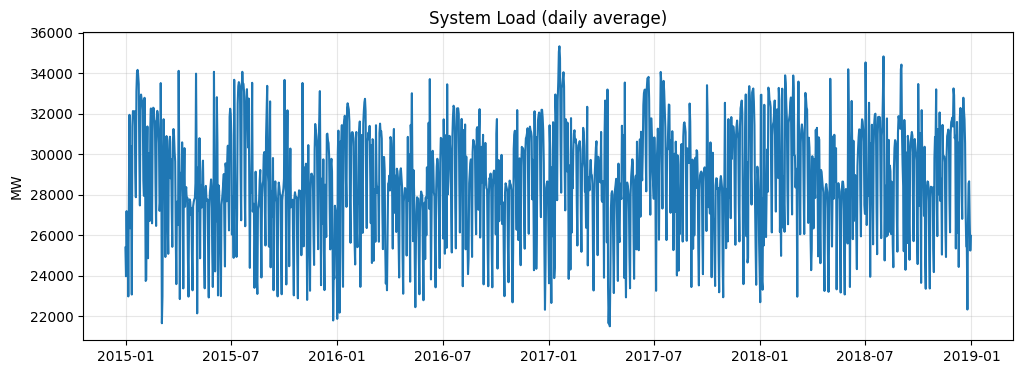

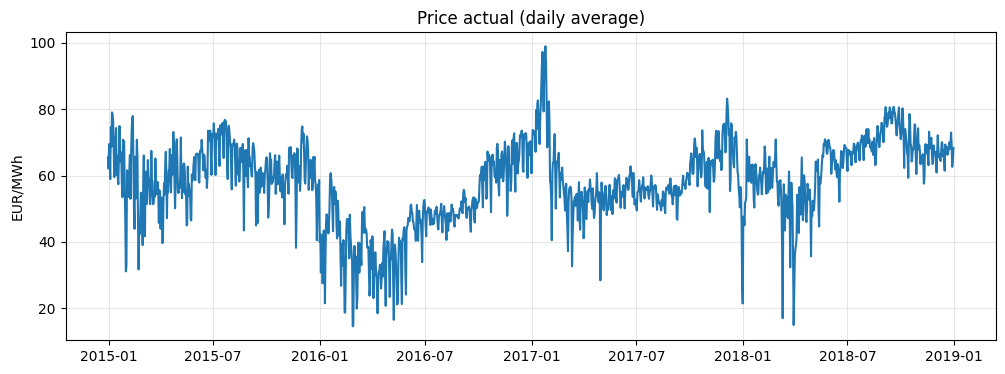

In [34]:
# Load & Price: Overall Trend (Hourly → Daily Mean, Denoised)

daily = energy_data[['total load actual','price actual']].resample('D').mean()

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(daily.index, daily['total load actual'], label='Load (daily mean)')
ax1.set_ylabel('MW')
ax1.set_title('System Load (daily average)')
ax1.grid(True, alpha=0.3)

fig, ax2 = plt.subplots(figsize=(12,4))
ax2.plot(daily.index, daily['price actual'], label='Price actual (daily mean)')
ax2.set_ylabel('EUR/MWh')
ax2.set_title('Price actual (daily average)')
ax2.grid(True, alpha=0.3)
plt.show()


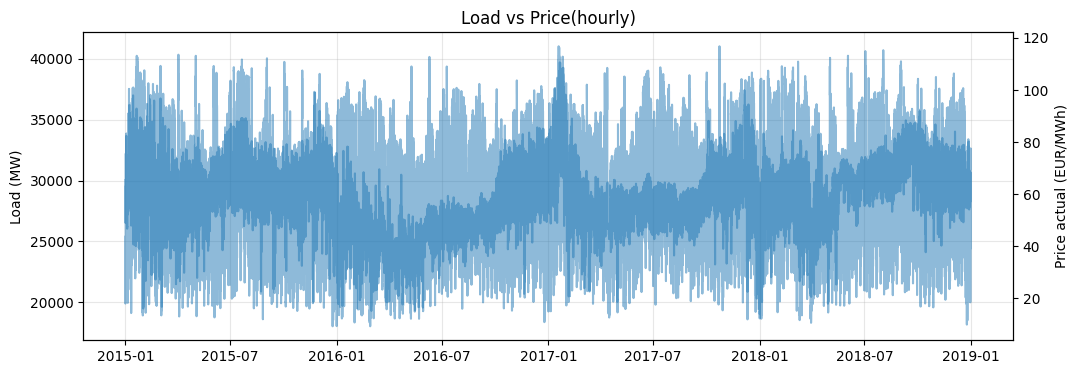

In [35]:
# Load & Price: Dual-Axis View (Hourly Detail)

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(energy_data.index, energy_data['total load actual'], alpha=0.5)
ax1.set_ylabel('Load (MW)')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(energy_data.index, energy_data['price actual'], alpha=0.5)
ax2.set_ylabel('Price actual (EUR/MWh)')
ax1.set_title('Load vs Price(hourly)')
plt.show()


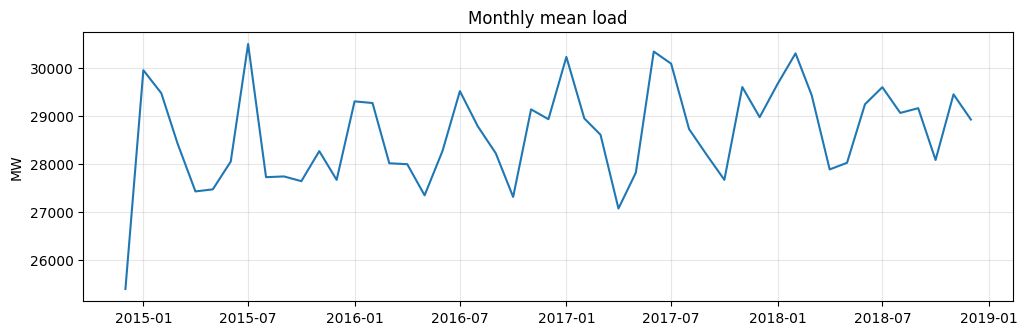

In [36]:
# Seasonality – Monthly

monthly = energy_data['total load actual'].resample('MS').mean()
fig, ax = plt.subplots(figsize=(12,3.5))
ax.plot(monthly.index, monthly.values)
ax.set_title('Monthly mean load')
ax.set_ylabel('MW'); ax.grid(True, alpha=0.3)

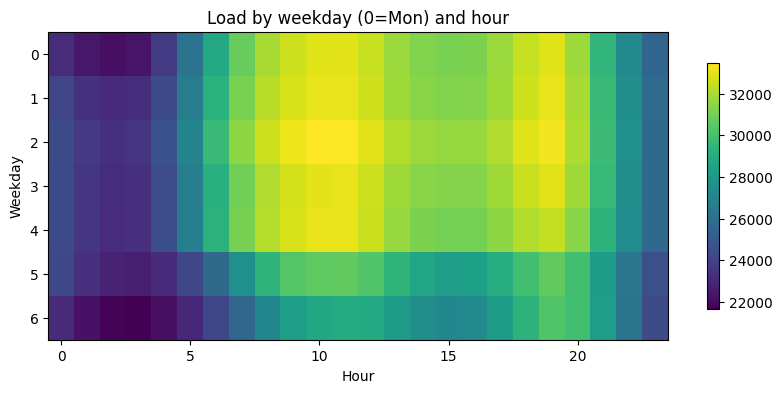

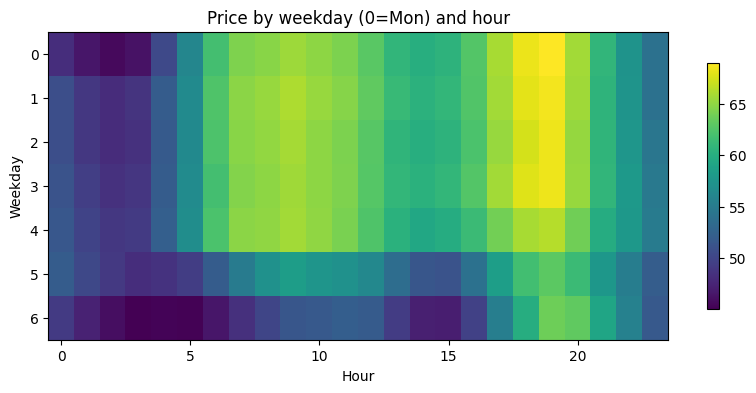

In [37]:
# Weekday–Hour Seasonality (Grouped by Hour)

gp = energy_data['total load actual'].groupby([energy_data.index.dayofweek,
                                               energy_data.index.hour]).mean().unstack()
fig, ax = plt.subplots(figsize=(10,4))
im = ax.imshow(gp, aspect='auto')
ax.set_title('Load by weekday (0=Mon) and hour')
ax.set_xlabel('Hour'); ax.set_ylabel('Weekday')
fig.colorbar(im, ax=ax, shrink=0.8)
plt.show()


# Price: Weekday–Hour Seasonality (Grouped by Hour)

gp = energy_data['price actual'].groupby([energy_data.index.dayofweek,
                                               energy_data.index.hour]).mean().unstack()
fig, ax = plt.subplots(figsize=(10,4))
im = ax.imshow(gp, aspect='auto')
ax.set_title('Price by weekday (0=Mon) and hour')
ax.set_xlabel('Hour'); ax.set_ylabel('Weekday')
fig.colorbar(im, ax=ax, shrink=0.8)
plt.show()



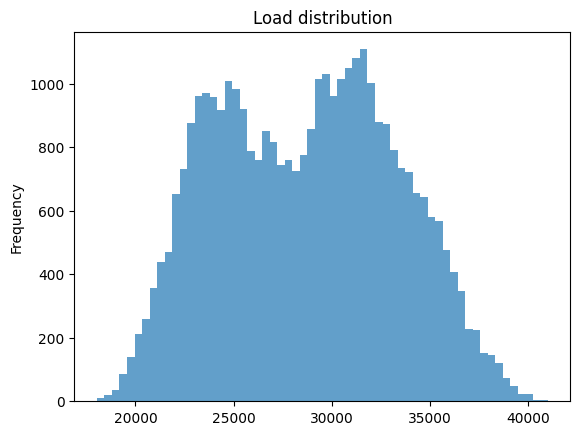

In [38]:
# load distribution
yL = energy_data["total load actual"]
yL.plot(kind="hist", bins=60, alpha=.7, title="Load distribution"); plt.show()

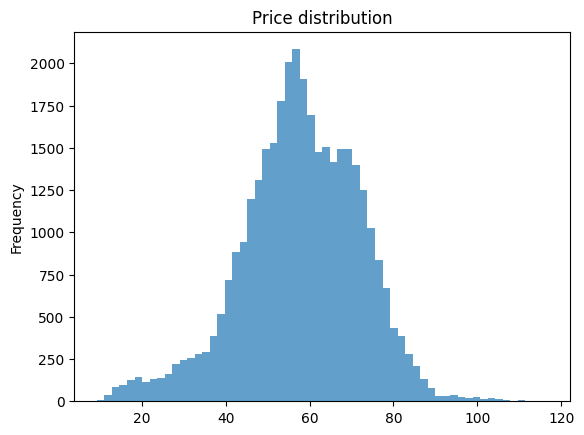

Price < 0 ratio: 0.0


In [39]:
# price distribution
yP = energy_data["price actual"]
yP.plot(kind="hist", bins=60, alpha=.7, title="Price distribution"); plt.show()
print("Price < 0 ratio:", (yP<0).mean())


In [40]:
def plot_acf_clean(s, max_lag=200, title="", highlight=(), daily=False):
    s = s.dropna()
    if daily:
        s = s.resample("D").mean()
    fig, ax = plt.subplots(figsize=(7,4))
    plot_acf(s, lags=max_lag, ax=ax, zero=False, alpha=0.05)
    ax.set_title(title)
    ax.set_xlim(0, max_lag)
    ax.set_ylim(-1.0, 1.0)
    ax.grid(True, alpha=0.3)
    for k in highlight:
        if k <= max_lag:
            ax.axvline(k, color="k", linestyle="--", linewidth=0.8, alpha=0.6)
            ax.text(k+1, 0.88, str(k), fontsize=9, alpha=0.7)
    plt.tight_layout()
    plt.show()





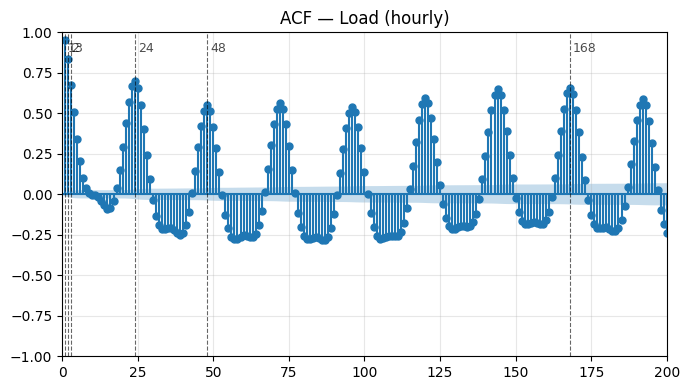

In [41]:
# import plot_acf

from statsmodels.graphics.tsaplots import plot_acf
# Load: ACF (Hourly)
plot_acf_clean(yL, max_lag=200, title="ACF — Load (hourly)",
               highlight=(1,2,3,24,48,168), daily=False)


action: load lags: 1, 2, 3, 24, 25, 48, 168 + rolling stats: 24, 168 on shift (1)

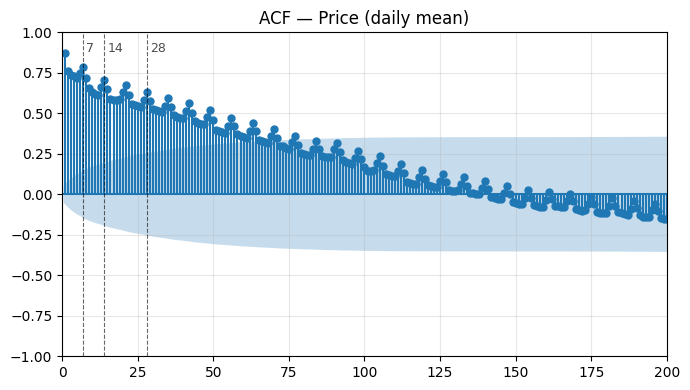

In [42]:
# Price: ACF (Daily Mean)
plot_acf_clean(yP, max_lag=200, title="ACF — Price (daily mean)",
               highlight=(7,14,28), daily=True)

actions: price daily lags: 1, 2, 7, 14, 28 + rolling stats: 7, 14, 28 on shift(1)

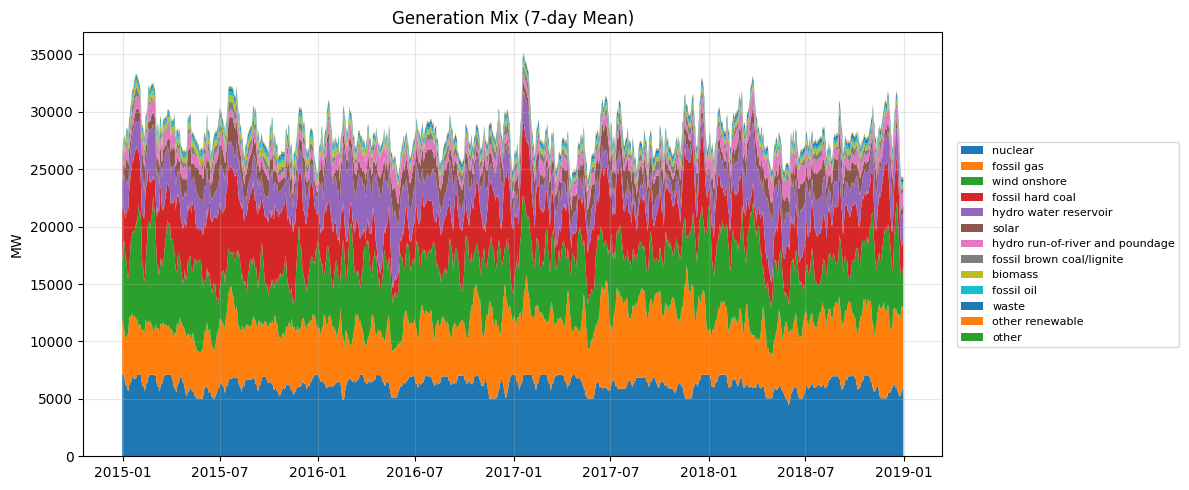

In [43]:
# Generation Mix (Daily Mean): 

gen_cols = [c for c in energy_data.columns if c.startswith('generation ') and
            'pumped storage consumption' not in c]  # 
# Daily mean to reduce visual noise
gen_daily = energy_data[gen_cols].resample('D').mean()
gen_smooth = gen_daily.rolling(window=7, min_periods=1).mean()

order = gen_smooth.mean().sort_values(ascending=False).index
labels = [c.replace('generation ', '') for c in order]

fig, ax = plt.subplots(figsize=(12,5))
ax.stackplot(gen_smooth.index, gen_smooth[order].T.values, labels=labels)
ax.set_title('Generation Mix (7-day Mean)')
ax.set_ylabel('MW'); ax.grid(True, alpha=0.3)
ax.legend(ncols=1, fontsize=8, loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.tight_layout()
plt.show()


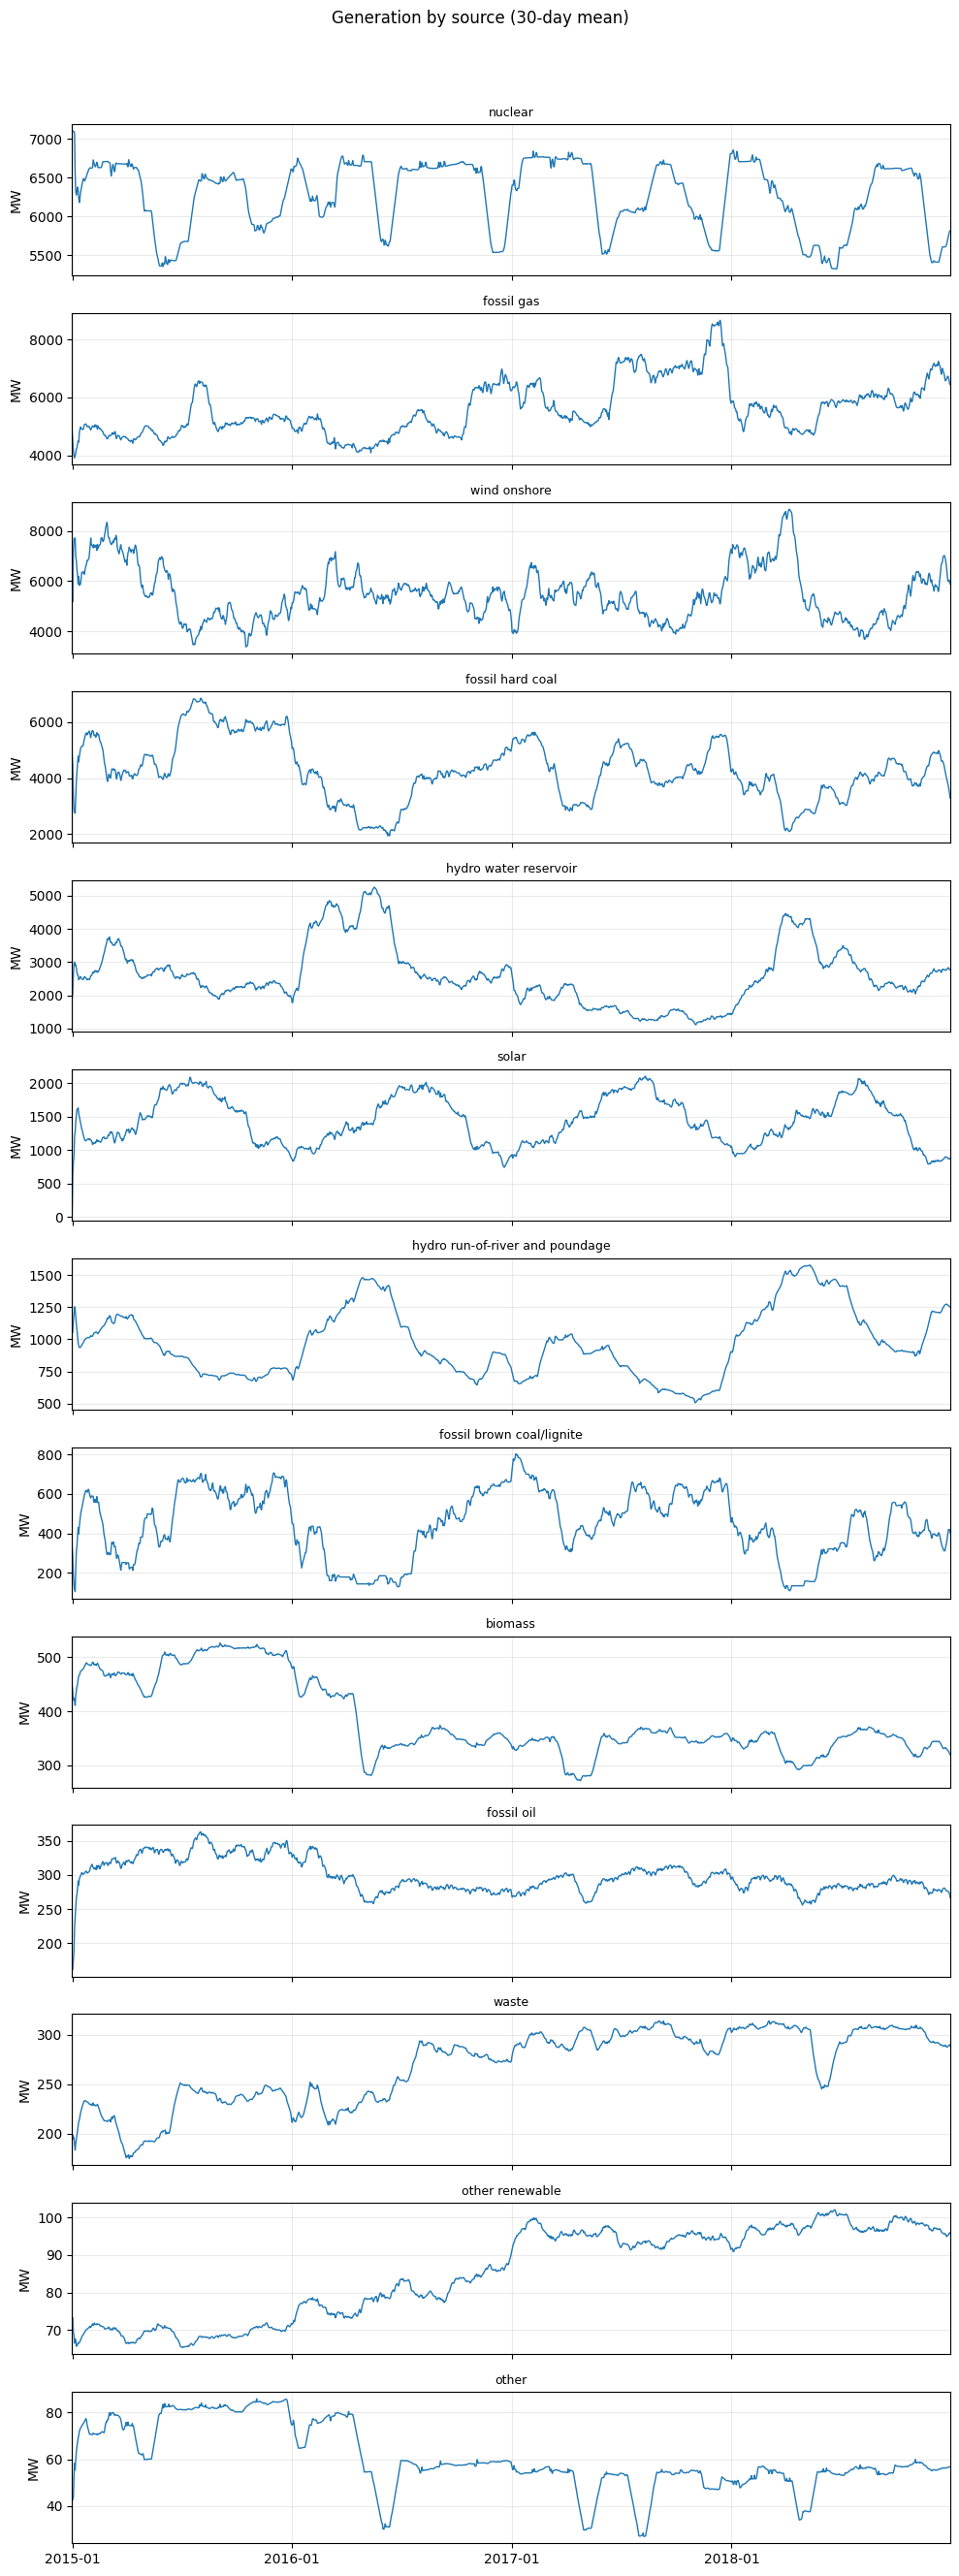

In [44]:
# Generation by Source (30-day Mean): Small Multiples

import matplotlib.dates as mdates

# 1) Prepare series: daily mean + 30-day rolling mean; order by long-run average
gen_cols = [c for c in energy_data.columns
            if c.startswith('generation ') and 'pumped storage consumption' not in c]
gen_daily  = energy_data[gen_cols].resample('D').mean()
gen_roll30 = gen_daily.rolling(30, min_periods=1).mean()
order = gen_roll30.mean().sort_values(ascending=False).index
titles = [c.replace('generation ', '') for c in order]

# 2) Small multiples: share the same X axis across plots, keep independent Y axes
n = len(order); ncols = 1
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 2*nrows), sharex=True)  # sharex=True !
axes = axes.ravel()

xmin, xmax = gen_roll30.index.min(), gen_roll30.index.max()
locator = mdates.YearLocator()       
fmt     = mdates.DateFormatter('%Y-%m')

for i, col in enumerate(order):
    ax = axes[i]
    ax.plot(gen_roll30.index, gen_roll30[col], linewidth=1.0)
    ax.set_title(titles[i], fontsize=9)
    ax.set_xlim(xmin, xmax)          
    ax.grid(True, alpha=0.25)
    if i % ncols == 0:
        ax.set_ylabel('MW')          
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(fmt)

# 3) Hide X labels on inner plots; show them only on the bottom row
for ax in axes:
    ax.label_outer()

# Turn off any unused subplots (when grid has extra slots)
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Generation by source (30-day mean)', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


**Findings**

- Seasonality: Strong annual cycle and clear weekday–hour pattern in load; solar peaks in summer, near-zero in winter.

- Load–Price relation: Co-movement is visible, but price is much more volatile with occasional spikes.

- Renewables: Onshore wind changes a lot from week to week. Solar is smaller overall but very seasonal.

- Fossil Gas/coal： average level can shift for several weeks or months.

- Hydro: Reservoir and run-of-river plants smooth peaks and valleys and show clear seasons.


#### 1.3.2 weather data visualization

In [45]:
weather_data.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_description
time,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475000,270.475000,270.475000,1001,77,1,62,0.0,0.0,0.0,0,800,sky is clear
2014-12-31 23:00:00+00:00,Seville,273.375000,273.375000,273.375000,1039,75,1,21,0.0,0.0,0.0,0,800,sky is clear
2014-12-31 23:00:00+00:00,Madrid,267.325000,267.325000,267.325000,971,63,1,309,0.0,0.0,0.0,0,800,sky is clear
2014-12-31 23:00:00+00:00,Barcelona,281.625000,281.625000,281.625000,1035,100,7,58,0.0,0.0,0.0,0,800,sky is clear
2014-12-31 23:00:00+00:00,Bilbao,269.657312,269.657312,269.657312,1036,97,0,226,0.0,0.0,0.0,0,800,sky is clear


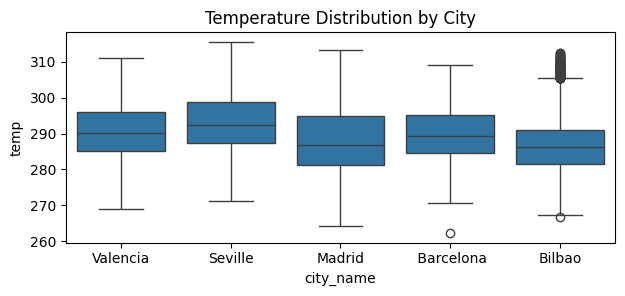

In [46]:
# visualization of temperature data
plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
sns.boxplot(x='city_name', y='temp', data=weather_data)
plt.title('Temperature Distribution by City')
plt.tight_layout()
plt.show()      

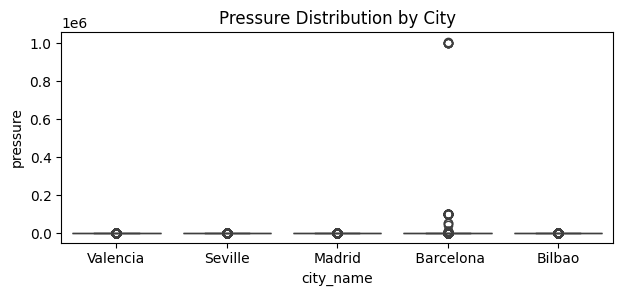

In [47]:
# Visualization of pressure data
plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
sns.boxplot(x='city_name', y='pressure', data=weather_data)
plt.title('Pressure Distribution by City')
plt.tight_layout()
plt.show()

Outliers: the pressure unit might be wrong

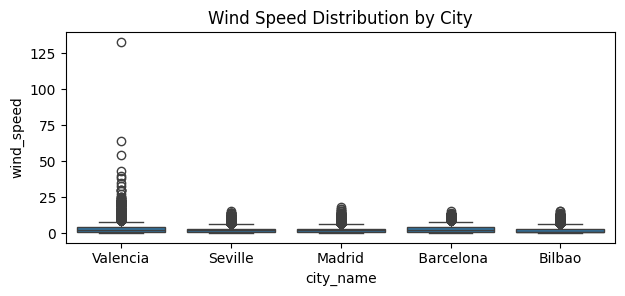

In [48]:
# visualization of wind speed data
plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
sns.boxplot(x='city_name', y='wind_speed', data=weather_data)
plt.title('Wind Speed Distribution by City')
plt.tight_layout()
plt.show()

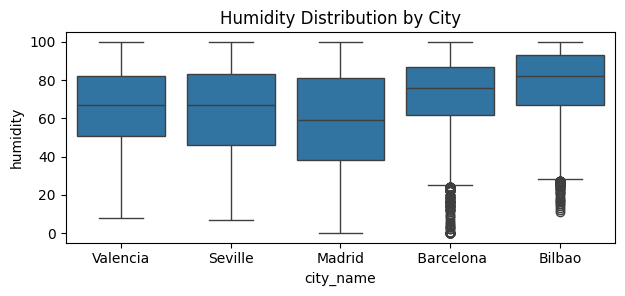

In [49]:
# visualization of humidity data
plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
sns.boxplot(x='city_name', y='humidity', data=weather_data)
plt.title('Humidity Distribution by City')
plt.tight_layout()
plt.show() 

In [50]:
weather_data.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_description
time,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475000,270.475000,270.475000,1001,77,1,62,0.0,0.0,0.0,0,800,sky is clear
2014-12-31 23:00:00+00:00,Seville,273.375000,273.375000,273.375000,1039,75,1,21,0.0,0.0,0.0,0,800,sky is clear
2014-12-31 23:00:00+00:00,Madrid,267.325000,267.325000,267.325000,971,63,1,309,0.0,0.0,0.0,0,800,sky is clear
2014-12-31 23:00:00+00:00,Barcelona,281.625000,281.625000,281.625000,1035,100,7,58,0.0,0.0,0.0,0,800,sky is clear
2014-12-31 23:00:00+00:00,Bilbao,269.657312,269.657312,269.657312,1036,97,0,226,0.0,0.0,0.0,0,800,sky is clear


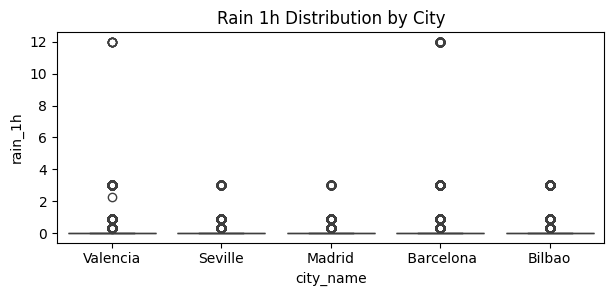

In [51]:
# visualization of rain_1h data
plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
sns.boxplot(x='city_name', y='rain_1h', data=weather_data)
plt.title('Rain 1h Distribution by City')
plt.tight_layout()
plt.show()

In [52]:
weather_data["rain_1h"].describe()

count    175320.000000
mean          0.069308
std           0.385915
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: rain_1h, dtype: float64

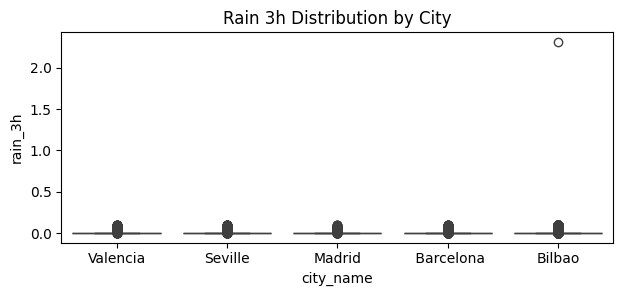

In [53]:
# visualization of rain_3h data
plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
sns.boxplot(x='city_name', y='rain_3h', data=weather_data)
plt.title('Rain 3h Distribution by City')
plt.tight_layout()
plt.show()

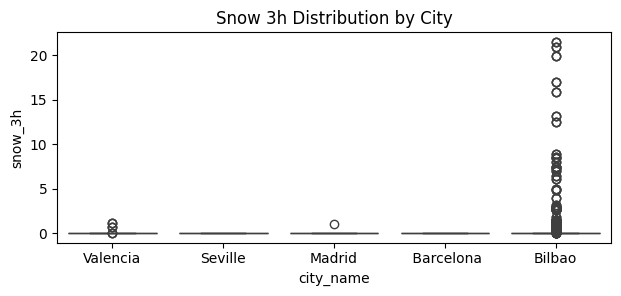

In [54]:
# visualization of snow_3h data
plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
sns.boxplot(x='city_name', y='snow_3h', data=weather_data)
plt.title('Snow 3h Distribution by City')
plt.tight_layout()
plt.show()

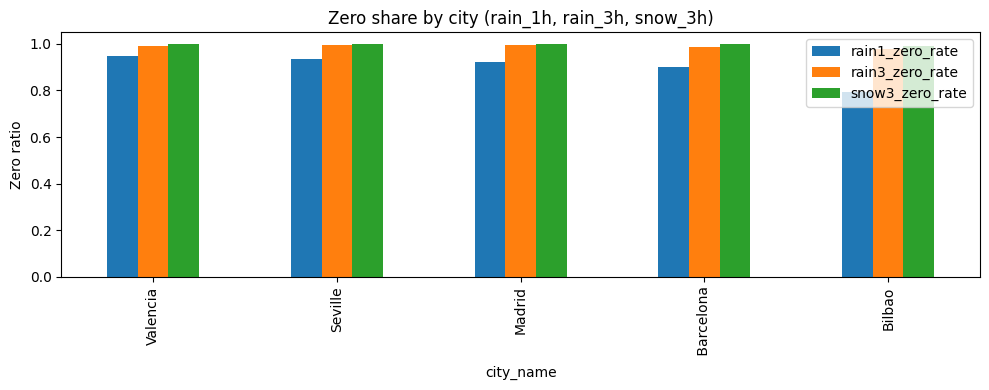

In [55]:
# ---- Zero Rain/Snow Analysis ----
def zero_ratio(s):
    return (s==0).mean()

zr = weather_data.groupby('city_name').agg(
    rain1_zero_rate=('rain_1h', zero_ratio),
    rain3_zero_rate=('rain_3h', zero_ratio),
    snow3_zero_rate=('snow_3h', zero_ratio),
).sort_values(['rain1_zero_rate', 'rain3_zero_rate', 'snow3_zero_rate'], ascending=False)

ax = zr.plot(kind='bar', figsize=(10,4))
ax.set_ylabel('Zero ratio')
ax.set_title('Zero share by city (rain_1h, rain_3h, snow_3h)')
plt.tight_layout(); plt.show()

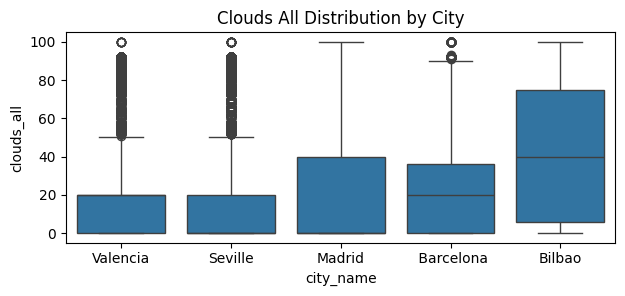

In [56]:
# visualization of clouds_all data
plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
sns.boxplot(x='city_name', y='clouds_all', data=weather_data)
plt.title('Clouds All Distribution by City')
plt.tight_layout()
plt.show()

It doesn't rain or snow on most days across all 5 cities

### 1.4 Summary

**Key Findings**

- Load has highly correlation with lag 1, 2, 3, 24, 48, 168

- Daily price has highly correlation with date lag 1, 2, 7, 14, 28

- Seasonality: Strong annual cycle and clear weekday–hour pattern in load; solar peaks in summer, near-zero in winter.

- Load–Price relation: Co-movement is visible, but price is much more volatile with occasional spikes.

- Renewables: Onshore wind changes a lot from week to week. Solar is smaller overall but very seasonal.

- Fossil Gas/coal： average level can shift for several weeks or months.

- Hydro: Reservoir and run-of-river plants smooth peaks and valleys and show clear seasons.

- It doesn't rain or snow on most days


**Acions**
- clean weather data: rolling clipping temp, pressure, wind_speed, huminity; diff temp
- merge energy and weather data
- parse date and add time features: hour, day of week, is_weekend, month, season, sin/cos, holidays
- take load and price values of previous day at the same time as baseline 1: daily lag 24
- split trian, validation, and test
- apart from lag 24, add lag 48, lag 168 of load, 
- add rolling mean 3, rolling 12, rolling 24, rolling 168 on shift(24) of load
- apart from lag 24, add lag 48, lag 168 of price
- add rolling mean 3, rolling 12, rolling 24, rolling 168 on shift 24 of price
- do a first validation
- with all known feature to predict the load and price again, by using VAR, LSTM, TFT

## 2. Data Preprocessing

### 2.1 weather data preprocessing

In [57]:
def roll_clip_mad(
    df: pd.DataFrame,
    col: str,
    group: str = "city_name",
    w: int = 45*24,          # window in hours (e.g., 45 days for temperature)
    k: float = 5.0,          # robustness factor (larger = more conservative)
    n_min: int = 24,         # minimum past samples required to enable clipping
    lower_phys: float | None = None,   # optional physical lower bound
    upper_phys: float | None = None,   # optional physical upper bound
) -> pd.DataFrame:
    """
    Causal rolling MAD clipping per city (does NOT overwrite the original column).

    Rule: x_clip = clip(x, median_past ± k * 1.4826 * MAD_past)
    - Uses only past values: shift(1) before rolling.
    - If past count < n_min, clipping is disabled at that timestamp.
    - Writes result to `col + "_clip"` and keeps the original column intact.
    """
    out = df.copy().sort_index()
    x = out[col].astype(float)

    # past-only series
    s_past = out.groupby(group)[col].transform(lambda s: s.shift(1))

    # rolling median and MAD per city
    med = s_past.groupby(out[group]).transform(lambda s: s.rolling(w, min_periods=1).median())
    mad = (s_past - med).abs().groupby(out[group]).transform(
            lambda s: s.rolling(w, min_periods=1).median())
    sigma = (1.4826 * mad).clip(lower=1e-6)  # avoid zero-width bands

    # enable clipping only when we have enough past data
    cnt = s_past.groupby(out[group]).transform(lambda s: s.rolling(w, min_periods=1).count())
    lo = np.where(cnt >= n_min, med - k * sigma, -np.inf)
    hi = np.where(cnt >= n_min, med + k * sigma,  np.inf)

    x_clip = x.clip(lower=lo, upper=hi)

    # optional physical bounds
    if lower_phys is not None:
        x_clip = x_clip.clip(lower=lower_phys)
    if upper_phys is not None:
        x_clip = x_clip.clip(upper=upper_phys)

    out[col + "_clip"] = x
    out[col + "_clip"] = x_clip
    return out

# Temperature (Kelvin): conservative bands for all cities
wd = roll_clip_mad(weather_data, col="temp", w=45*24, k=5, n_min=24, lower_phys=250, upper_phys=325)

# Pressure (after unit fix), shorter window
wd["pressure"] = np.where(wd["pressure"] > 2000, wd["pressure"]/1000, wd["pressure"])
wd = roll_clip_mad(wd, col="pressure", w=14*24, k=3, n_min=24, lower_phys=870, upper_phys=1100)

# wind speed
wd = roll_clip_mad(wd, col="wind_speed", w=30*24, k=3, n_min=24, lower_phys=0, upper_phys=60)

# humidity
wd = roll_clip_mad(wd, col="humidity", w=30*24, k=3, n_min=24, lower_phys=0, upper_phys=100)

# clouds_all
wd = roll_clip_mad(wd, col="clouds_all", w=30*24, k=3, n_min=24, lower_phys=0, upper_phys=100)

wd["temp_range"] = wd["temp_max"] - wd["temp_min"]

In [58]:
wd.columns

Index(['city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'weather_description', 'temp_clip', 'pressure_clip',
       'wind_speed_clip', 'humidity_clip', 'clouds_all_clip', 'temp_range'],
      dtype='object')

In [59]:
keep_wcols = ["city_name",
              "temp_clip",
              "pressure_clip",
              "wind_speed_clip",
              "humidity_clip",
              "clouds_all_clip",
              "rain_1h",
              "temp_min",
              "temp_max",
              "temp_range",] # for the sake of simplicity, only keep these weather columns

cwd = wd[keep_wcols]

In [60]:
cwd.head() # we will upper clip rain_1h after splitting training and test sets

,city_name,temp_clip,pressure_clip,wind_speed_clip,humidity_clip,clouds_all_clip,rain_1h,temp_min,temp_max,temp_range
time,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475000,1001.0,1.0,77.0,0.0,0.0,270.475000,270.475000,0.0
2014-12-31 23:00:00+00:00,Seville,273.375000,1039.0,1.0,75.0,0.0,0.0,273.375000,273.375000,0.0
2014-12-31 23:00:00+00:00,Madrid,267.325000,971.0,1.0,63.0,0.0,0.0,267.325000,267.325000,0.0
2014-12-31 23:00:00+00:00,Barcelona,281.625000,1035.0,7.0,100.0,0.0,0.0,281.625000,281.625000,0.0
2014-12-31 23:00:00+00:00,Bilbao,269.657312,1036.0,0.0,97.0,0.0,0.0,269.657312,269.657312,0.0


In [61]:
# pivot to wide format

vars_to_expand = ['temp_clip', 'pressure_clip', 'wind_speed_clip', 'humidity_clip', "clouds_all_clip", "rain_1h", "temp_range"]
wide = cwd.pivot_table(index="time", columns="city_name", values=vars_to_expand, aggfunc="first")

new_cols = []
for col in wide.columns:
    var, city = col
    var = var.strip()
    city = city.strip()
    new_cols.append(f"{var}_city_{city}")
wide.columns = new_cols

wide_weather = wide.sort_index(axis=1)

In [62]:
wide_weather.head()

,clouds_all_clip_city_Barcelona,clouds_all_clip_city_Bilbao,clouds_all_clip_city_Madrid,clouds_all_clip_city_Seville,clouds_all_clip_city_Valencia,humidity_clip_city_Barcelona,humidity_clip_city_Bilbao,humidity_clip_city_Madrid,humidity_clip_city_Seville,humidity_clip_city_Valencia,pressure_clip_city_Barcelona,pressure_clip_city_Bilbao,pressure_clip_city_Madrid,pressure_clip_city_Seville,pressure_clip_city_Valencia,rain_1h_city_Barcelona,rain_1h_city_Bilbao,rain_1h_city_Madrid,rain_1h_city_Seville,rain_1h_city_Valencia,temp_clip_city_Barcelona,temp_clip_city_Bilbao,temp_clip_city_Madrid,temp_clip_city_Seville,temp_clip_city_Valencia,temp_range_city_Barcelona,temp_range_city_Bilbao,temp_range_city_Madrid,temp_range_city_Seville,temp_range_city_Valencia,wind_speed_clip_city_Barcelona,wind_speed_clip_city_Bilbao,wind_speed_clip_city_Madrid,wind_speed_clip_city_Seville,wind_speed_clip_city_Valencia
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,0.0,0.0,0.0,0.0,0.0,100.0,97.0,63.0,75.0,77.0,1035.0,1036.0,971.0,1039.0,1001.0,0.0,0.0,0.0,0.0,0.0,281.625,269.657312,267.325,273.375,270.475,0.0,0.0,0.0,0.0,0.0,7.0,0.0,1.0,1.0,1.0
2015-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,100.0,97.0,63.0,75.0,77.0,1035.0,1035.0,971.0,1039.0,1001.0,0.0,0.0,0.0,0.0,0.0,281.625,269.763500,267.325,273.375,270.475,0.0,0.0,0.0,0.0,0.0,7.0,0.0,1.0,1.0,1.0
2015-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,100.0,97.0,64.0,71.0,78.0,1036.0,1036.0,971.0,1039.0,1002.0,0.0,0.0,0.0,0.0,0.0,281.286,269.251688,266.186,274.086,269.686,0.0,0.0,0.0,0.0,0.0,7.0,1.0,1.0,3.0,0.0
2015-01-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,100.0,97.0,64.0,71.0,78.0,1036.0,1035.0,971.0,1039.0,1002.0,0.0,0.0,0.0,0.0,0.0,281.286,269.203344,266.186,274.086,269.686,0.0,0.0,0.0,0.0,0.0,7.0,1.0,1.0,3.0,0.0
2015-01-01 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,100.0,97.0,64.0,71.0,78.0,1036.0,1035.0,971.0,1039.0,1002.0,0.0,0.0,0.0,0.0,0.0,281.286,269.485500,266.186,274.086,269.686,0.0,0.0,0.0,0.0,0.0,7.0,1.0,1.0,3.0,0.0


### 2.2 Data merging

In [63]:
# merge energy_data and wide_weather on time index
energy_data = energy_data.sort_index()
wide_weather = wide_weather.sort_index()
df = energy_data.join(wide_weather, how="left", rsuffix="_wx").sort_index()

In [65]:
# Check df.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 53 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35064 non-null  float64
 1   generation fossil brown coal/lignite         35064 non-null  float64
 2   generation fossil gas                        35064 non-null  float64
 3   generation fossil hard coal                  35064 non-null  float64
 4   generation fossil oil                        35064 non-null  float64
 5   generation hydro pumped storage consumption  35064 non-null  float64
 6   generation hydro run-of-river and poundage   35064 non-null  float64
 7   generation hydro water reservoir             35064 non-null  float64
 8   generation nuclear                           35064 non-null  float64
 9   generation other         

In [66]:
# Check time continuity
time_diff = df.index.to_series().diff().dropna()
missing_intervals = time_diff[time_diff != pd.Timedelta(hours=1)]
print(f"Number of missing time intervals after merge: {len(missing_intervals)}")

Number of missing time intervals after merge: 0


In [67]:
# check duplicate entries
duplicate_entries = df[df.duplicated()]
print(f"Number of duplicate entries: {len(duplicate_entries)}")

Number of duplicate entries: 0


### 2.3 Time Features Engineering

In [68]:
# add time features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# add is_weekend feature
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

import holidays
years = pd.Index(df.index.year).unique().tolist()
spain_holidays = holidays.country_holidays("ES", years=years)
dates = pd.Series(df.index.date, index=df.index)
df["is_holiday"] = dates.isin(spain_holidays).astype("int8")

In [69]:
df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load actual,price actual,clouds_all_clip_city_Barcelona,clouds_all_clip_city_Bilbao,clouds_all_clip_city_Madrid,clouds_all_clip_city_Seville,clouds_all_clip_city_Valencia,humidity_clip_city_Barcelona,humidity_clip_city_Bilbao,humidity_clip_city_Madrid,humidity_clip_city_Seville,humidity_clip_city_Valencia,pressure_clip_city_Barcelona,pressure_clip_city_Bilbao,pressure_clip_city_Madrid,pressure_clip_city_Seville,pressure_clip_city_Valencia,rain_1h_city_Barcelona,rain_1h_city_Bilbao,rain_1h_city_Madrid,rain_1h_city_Seville,rain_1h_city_Valencia,temp_clip_city_Barcelona,temp_clip_city_Bilbao,temp_clip_city_Madrid,temp_clip_city_Seville,temp_clip_city_Valencia,temp_range_city_Barcelona,temp_range_city_Bilbao,temp_range_city_Madrid,temp_range_city_Seville,temp_range_city_Valencia,wind_speed_clip_city_Barcelona,wind_speed_clip_city_Bilbao,wind_speed_clip_city_Madrid,wind_speed_clip_city_Seville,wind_speed_clip_city_Valencia,hour,dayofweek,month,is_weekend,is_holiday
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17.0,6436.0,25385.0,65.41,0.0,0.0,0.0,0.0,0.0,100.0,97.0,63.0,75.0,77.0,1035.0,1036.0,971.0,1039.0,1001.0,0.0,0.0,0.0,0.0,0.0,281.625,269.657312,267.325,273.375,270.475,0.0,0.0,0.0,0.0,0.0,7.0,0.0,1.0,1.0,1.0,23,2,12,0,0
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16.0,5856.0,24382.0,64.92,0.0,0.0,0.0,0.0,0.0,100.0,97.0,63.0,75.0,77.0,1035.0,1035.0,971.0,1039.0,1001.0,0.0,0.0,0.0,0.0,0.0,281.625,269.763500,267.325,273.375,270.475,0.0,0.0,0.0,0.0,0.0,7.0,0.0,1.0,1.0,1.0,0,3,1,0,1
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8.0,5454.0,22734.0,64.48,0.0,0.0,0.0,0.0,0.0,100.0,97.0,64.0,71.0,78.0,1036.0,1036.0,971.0,1039.0,1002.0,0.0,0.0,0.0,0.0,0.0,281.286,269.251688,266.186,274.086,269.686,0.0,0.0,0.0,0.0,0.0,7.0,1.0,1.0,3.0,0.0,1,3,1,0,1
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2.0,5151.0,21286.0,59.32,0.0,0.0,0.0,0.0,0.0,100.0,97.0,64.0,71.0,78.0,1036.0,1035.0,971.0,1039.0,1002.0,0.0,0.0,0.0,0.0,0.0,281.286,269.203344,266.186,274.086,269.686,0.0,0.0,0.0,0.0,0.0,7.0,1.0,1.0,3.0,0.0,2,3,1,0,1
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9.0,4861.0,20264.0,56.04,0.0,0.0,0.0,0.0,0.0,100.0,97.0,64.0,71.0,78.0,1036.0,1035.0,971.0,1039.0,1002.0,0.0,0.0,0.0,0.0,0.0,281.286,269.485500,266.186,274.086,269.686,0.0,0.0,0.0,0.0,0.0,7.0,1.0,1.0,3.0,0.0,3,3,1,0,1


In [70]:
df.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load actual', 'price actual', 'clouds_all_clip_city_Barcelona',
       'clouds_all_clip_city_Bilbao', 'clouds_all_clip_city_Madrid',
       'clouds_all_clip_city_Seville', 'clouds_all_clip_city_Valencia',
       'humidity_clip_city_Barcelona', 'humidity_clip_city_Bilbao',
       'humidity_clip_city_Madrid', 'humidity_clip_city_Seville',
       'humidity_clip_city_Valencia', 'pressure_clip_city_Barcelona',
       'pressure_clip_city_Bilbao', 'pressure_c

### 2.4 Feature Engineering

In [ ]:
# lag, rolling mean
 